## IMPORTANT:
Some manual work is required in order for this notebook to work properly. The places are marked with "**# USER-INPUT**" and explain what you have to do.

## Algorithm
1. Download the publication data for each author from Google Scholar using scholarly.
2. Create a dictionary of titles with the corresponding authors from our group.
3. Tidy up the data by removing different versions.
4. Calculate collaboration measures.
5. Visualize.

## Notes
If you want to use the notebook for other sets of authors, you have to change the names and ids (which you can find in the URL of the corresponding Google Scholar page) given to the variables `authors` and `author_ids`. Often, the data has to be tidied up, which has to be done manually. We provide some help by first sorting the titles alphabetically and restricting the comparison to pairs of title with small Levenshtein distance.

Also, since Google Scholar does not have a public API (at least to my knowlege), we used the third party Python module scholarly. Since we also used the proxy functionality by scholarly (which is recommended to not get blocked by Google Scholar) retriving the data takes quite some time.

## TODO
* Provide the possibility to save data locally or in Google Drive, thus saving time (since we don't have to reload the Google Scholar data)
* Automate and enhance the tidying up-process
* Create coincidence matrices for conferences

## Necessary libraries

In [1]:
# If scholarly, NetworkX or levenshtein are not installed, manually install them
%pip install scholarly
%pip install NetworkX
%pip install levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.3 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.1-py3-none-any.whl size=43252 sha256=ecdd06638686d5e364b96396fd4f67e547342e0eca9471bb070b1438cd2ada54
  Stored in directory: /root/.

In [2]:
# Getting the data
from scholarly import scholarly
from scholarly import ProxyGenerator

# For cleaning the text data
from Levenshtein import distance
import copy

# Useful for calculations and visualizations
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Setup

In [3]:
# Determines how much (intermediary) data will be presented to you
# 0: No intermediary data will be presented to you (for presentations)
# 1: No intermediary data will be presented to you (for debugging)
# 2: No intermediary data will be presented to you (for searching for error)

verbosity = 1

## Fetching the data

In [4]:
# USER-INPUT: Names of authors
authors = ["Hao Li",
           "Zheng Xu",
           "Gavin Taylor",
           "Christoph Studer",
           "Tom Goldstein"]

# Number of authors
number_of_authors = len(authors)

# USER-INPUT: Names + Google Scholar Id's
# Can be found in the URL of the corresponding Google Scholar Profile Pages
# You'll recognize them once you see the pattern
author_ids = {
    "Hao Li"  : "BNEeEosAAAAJ",
    "Zheng Xu"    : "TfWlMTYAAAAJ",
    "Gavin Taylor"   : "hDqVCIoAAAAJ",
    "Christoph Studer" : "Jco5C7sAAAAJ",
    "Tom Goldstein"  : "KmSuVtgAAAAJ"
}

In [5]:
# Only run, if the object author_information does not yet exist
# Otherwise important data will be overwritten

author_information = {}
already_downloaded = {}

for name in authors:
  already_downloaded[name] = False

In [7]:
# Since we use free proxies, this might take a while (~1 minute to ~10 minutes)
# if too much time passes, the programm might throw an exception
# just rerun the cell (this is why I included the ability to reuse downloads)
for name in author_ids:

  if verbosity >= 1:
    print(name)
    print("-------------------------------------------------------------------")

  # Since Juypter Notebook/Google Colabs saves variables, we don't have to rerun
  # known queries; this saves time
  if already_downloaded[name]:

    if verbosity >= 1:
      print("Already downloaded")
      scholarly.pprint(author_information[name])
      print("-----------------------------------------------------------------")

    continue

  # Create a proxy using scholarly in order to not get banned by Google Scholar
  # Changing proxies every request seems to work best
  pg = ProxyGenerator()
  success = pg.FreeProxies()
  scholarly.use_proxy(pg)

  # Fetch the information
  id = author_ids[name]
  author = scholarly.search_author_id(id)

  pg = ProxyGenerator()
  success = pg.FreeProxies()
  scholarly.use_proxy(pg)

  author_more_information = scholarly.fill(author, sections = ["publications"])

  # Save it
  author_information[name] = author_more_information
  already_downloaded[name] = True

  if verbosity >= 1:
      print("Downloaded")
      scholarly.pprint(author_more_information)
      print("-----------------------------------------------------------------")

Hao Li
-------------------------------------------------------------------
Already downloaded
b"{'affiliation': 'AWS AI Labs',\n 'citedby': 6825,\n 'email_domain': '@amazon.com',\n 'filled': False,\n 'homepage': 'https://ljk628.github.io/',\n 'interests': ['Machine Learning', 'Computer Vision'],\n 'name': 'Hao Li',\n 'publications': [{'author_pub_id': 'BNEeEosAAAAJ:4JMBOYKVnBMC',\n                   'bib': {'citation': 'International Conference on Learning '\n                                       'Representations (ICLR), 2017',\n                           'pub_year': '2017',\n                           'title': 'Pruning Filters for Efficient ConvNets'},\n                   'citedby_url': 'https://scholar.google.com/scholar?oi=bibs&hl=en&cites=10756249335825111134',\n                   'cites_id': ['10756249335825111134'],\n                   'filled': False,\n                   'num_citations': 3989,\n                   'source': 'AUTHOR_PUBLICATION_ENTRY'},\n                  {'autho

## Ordering and cleaning the data

In [ ]:
# Take a look at the data
if verbosity >= 2:
  print(author_information)

In [113]:
# Create a dictionary with title -> authors/name data
title_authors = {}
titles = []

for author in authors:
  publications = author_information[author]["publications"]

  for publication in publications:
    if publication['container_type'] =='Publication':
      title = publication['bib']['title']

    if verbosity >= 2:
      print(title)

    # The title has already been entered, so there exist a coauthor
    if title in title_authors:

      # Some authors have the same paper several times, leading to overcounting
      if not author in title_authors[title]:
        title_authors[title].append(author)

    else: # The paper is not know yet
      title_authors[title] = [author]
      titles.append(title)

In [114]:
len(titles)

659

We now want to find different versions (as signalled by their name) of the same paper (since we don't want to overcount). Since in our estimation the names only change due to capitalization, adding version names, adding years, adding subtitles or fixing spelling mistakes, we can find most, if not all, of these duplicates by:
1. First ordering the titles alphabetically, so that similar spellings are grouped together.
2. Only looking at a fixed numer of following papers (since high differences in indices generally imply different initial letters and thus different papers).
3. Only looking at pairs of titles with small Levenshtein distances, which implies that most of the title is still the same.

This might not find all duplicates and will generally produce many false positive, so the output has to be manually checked.

In [115]:
# Order the titles alphabetically
titles.sort()

# Then compare Levenshtein distances
win_width = 10
max_ls = 30 # has to be fine-tuned (for us, 30 was a good fit)
# Note: ls = Levenshtein distance, win = window

max_len = len(titles)

# For each title
for index, first_title in enumerate(titles):
    # Go through a (fixed) number of alphabetically following numbers
    for offset_index in range(index + 1, min(index + win_width + 1, max_len)):
      second_title = titles[offset_index]

      # Calculate the Levenshtein distance
      # if the Levenshtein distance is greater than max_ls, the distance
      # function will terminate and return max_ls
      current_ls = distance(first_title,
                            second_title,
                            score_cutoff = max_ls)

      # Only display pairs of title with small Levenshtein distance
      # Due to the inner workings of the above distance function, we exclude
      # the prematurely terminated calculations, which would have exceeded the
      # maximal Levensthein distance anyway
      if current_ls <= max_len:
        print(f"{index}: {first_title}")
        print(f"{offset_index}: {second_title}")
        print(f"Distance: {current_ls}")
        print("--------------------------------------------------------------")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
528: Sparse factor analysis for analysis of user content preferences
534: Sparsity-adaptive beamspace channel estimation for 1-bit mmWave massive MIMO systems
Distance: 31
--------------------------------------------------------------
528: Sparse factor analysis for analysis of user content preferences
535: Sparsity-based real-time audio restoration
Distance: 31
--------------------------------------------------------------
528: Sparse factor analysis for analysis of user content preferences
536: Special Issue on the 2016 IEEE International Symposium on Circuits and Systems (ISCAS 2016)
Distance: 31
--------------------------------------------------------------
528: Sparse factor analysis for analysis of user content preferences
537: Splitting methods in communication, imaging, science, and engineering
Distance: 31
--------------------------------------------------------------
528: Sparse factor analysis for analysis of

In [116]:
# We now merge different versions of the same paper

# To get the list of tuples of indices you have to go through the
# above list manually (or maybe use a LLM; I did not test that)

# USER-INPUT: List of tuples of indices to merge
merges = [
  (642, 643)
]

# Rechecking
print("Rechecking:")
print("-------------------------------------------------------")
for merge in merges:
  for index in merge:
    print(titles[index])

  print("----------------------------------------------------")

# Actual merging
# In order to able to redo mistakes we create a new  dictionary
# with merged authors
title_merged_names = copy.deepcopy(title_authors) #NOT THREAD SAFE

for merge in merges:
  # We merge into the first index:
  first_index = merge[0]
  first_title = titles[first_index]
  merged_authors = title_merged_names[first_title]

  if verbosity >= 1:
    print(merged_authors)

  for index in merge:
    # Sentinal; as we do not want to merge an index with itself
    if index == first_index:
      continue

    current_title = titles[index]
    additional_authors = title_authors[current_title]

    if verbosity >= 1:
      print(additional_authors)

    # Actual merge
    for additional_author in additional_authors:
      # We only want to add authors not already present to avoid overcounting
      if not additional_author in merged_authors:
        merged_authors.append(additional_author)

    title_merged_names[first_title] = merged_authors

    # Deleting the useless titles (and thus avoid overcounting)
    title_merged_names.pop(current_title, None)

  if verbosity >= 1:
      print("--------------------------------------------------------")

Rechecking:
-------------------------------------------------------
Visualizing the Loss Landscape of Neural Nets
Visualizing the loss landscape of neural nets
----------------------------------------------------
['Hao Li']
['Zheng Xu', 'Gavin Taylor', 'Christoph Studer', 'Tom Goldstein']
--------------------------------------------------------


## Analysis

In [117]:
# Matrices and vectors that will hold the desired information

# Number of papers written by a pair of authors (with more possible coauthors
# from our group)
coauthor_matrix        = np.zeros((number_of_authors, number_of_authors))

# Number of papers written by exactly 1, 2, 3, ... or n authors from our group
coauthor_count_exact   = np.zeros(number_of_authors)

# Number of papers written by at least 1, 2, 3, ... or n authors from our group
coauthor_count_greater = np.zeros(number_of_authors)

# We go through the titles
for title in title_merged_names:
  # Get the (co)authors of the current paper
  coauthors = title_merged_names[title]

  # Note down the number of coauthors
  coauthor_count_exact[len(coauthors) - 1] += 1

  # Go through each author
  for author_first in coauthors:
    # Go through each author again
    # This ensures the matrix is symmetric and that papers with only one author
    # from our group are counted
    for author_second in coauthors:
      # Find the correct first author and second author
      index_author_first   = authors.index(author_first)
      index_author_second  = authors.index(author_second)

      # Note down which pair of authors has occured
      coauthor_matrix[index_author_first, index_author_second] += 1


# The number of papers written by the highest possible numbers of authors is the
# same for both approaches
coauthor_count_greater[-1] = coauthor_count_exact[-1]
# We start from the back, because only the back is filled in yet
for i in range(number_of_authors - 2, -1, -1):
  # Since >= is equivalent to > or =
  coauthor_count_greater[i] = coauthor_count_exact[i] +\
                              coauthor_count_greater[i + 1]

In [118]:
# Print the results
print(f"Coauthor matrix: \n{coauthor_matrix}")
print(f"Coauthor count (==): {coauthor_count_exact}")
print(f"Coauthor count (>=): {coauthor_count_greater}")

Coauthor matrix: 
[[ 20.   3.   1.   1.   1.]
 [  3.  62.   2.   3.   5.]
 [  1.   2.  40.   3.  16.]
 [  1.   3.   3. 310.  49.]
 [  1.   5.  16.  49. 300.]]
Coauthor count (==): [591.  62.   4.   0.   1.]
Coauthor count (>=): [658.  67.   5.   1.   1.]


## Visualizations

In [119]:
# Initializing the graph
G = nx.Graph()

# Adding the authors as nodes
for author in authors:
  G.add_node(author)

# Adding the numbers of papers written together as weighted edges
for index in range(0, number_of_authors):
  for coindex in range(0, number_of_authors):

    # Sentinal, since we don't want loops
    if index == coindex:
      continue

    # If a pair of authors did not write a paper together, we show a warning
    if coauthor_matrix[index, coindex] == 0:
      print("We found a pair of authors that did not write a paper together. +\
      Depending on your situation and purpose this should not happen.")

      print("If this is the case, this is often explained (in our estimation) +\
      due to insufficient data clean up. The paper(s) in question might have +\
      different version name for each author.")

    # Add a weighted edge
    G.add_edge(authors[index], authors[coindex],
               weight = coauthor_matrix[index, coindex])

# Short decription of the created graph
if verbosity >= 1:
  print(G)

Graph with 5 nodes and 10 edges


### Note:
The following plots are optimized for the presentation (transparent background). They will be saved automatically in the folder of your collab environment.

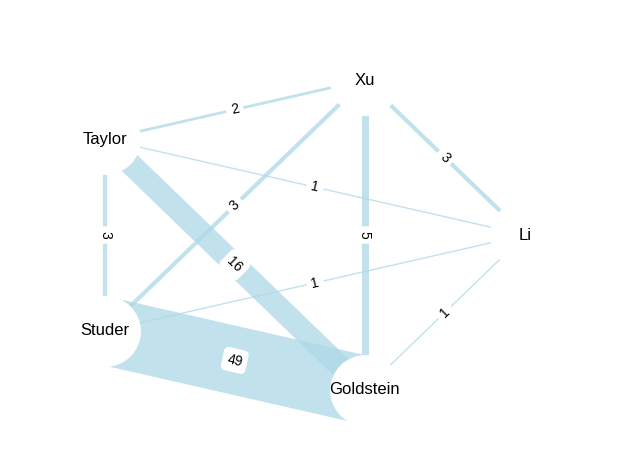

In [121]:
import networkx as nx
import matplotlib.pyplot as plt
import copy

# Assuming G is your networkx graph
# Calculate the node positions
G_filtered = G.copy()
mapping = {node: node.split()[-1] for node in G_filtered.nodes}
G_filtered = nx.relabel_nodes(G_filtered, mapping)
pos = nx.circular_layout(G_filtered)

# Remove edges with weight equal to 0
edges_to_remove = [(u, v) for u, v, w in G.edges(data='weight') if w == 0]
G_filtered.remove_edges_from(edges_to_remove)
# Draw the nodes
nx.draw_networkx_nodes(G_filtered, pos, node_size=2500, node_color="white")

# Draw the labels
nx.draw_networkx_labels(G_filtered, pos, font_size=12, font_family="sans-serif")

# Draw the edges
weights = nx.get_edge_attributes(G_filtered, "weight")
nx.draw_networkx_edges(G_filtered, pos, width=list(weights.values()),
                       edge_color="lightblue", alpha=0.75)

# Draw the edge labels
# We do a little more work to get rid of the (somewhat annoying) decimal point
weight_labels = copy.deepcopy(weights)  # NOT THREAD SAFE
for current_edge in weight_labels:
    weight_labels[current_edge] = str(int(weight_labels[current_edge]))
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=weight_labels)

# Technical details to get a more aesthetically pleasing graph
ax = plt.gca()
ax.margins(0.16)
plt.axis("off")
plt.tight_layout()
plt.savefig("network_plot.png", transparent=True)
plt.show()


In [36]:
import pandas as pd
author_df = pd.DataFrame(author_information).head(20)

<ipython-input-57-6bd3df30a1a0>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


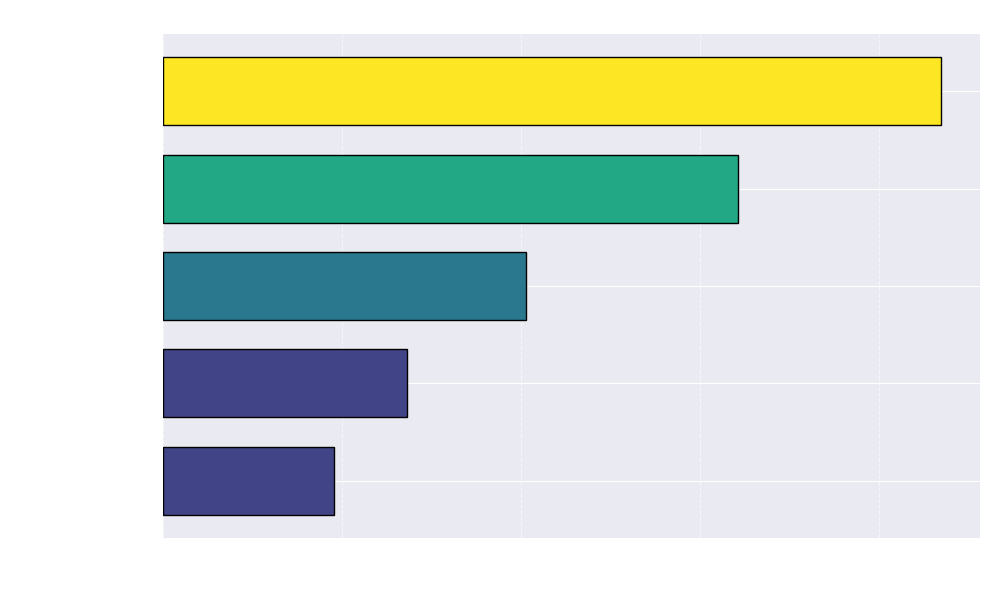

In [57]:
cites = author_df.loc["citedby"].to_dict()
sorted_cites = dict(sorted(cites.items(), key = lambda item: item[1], reverse = True))

# Set a custom style
plt.style.use('seaborn-darkgrid')

# Plot the bar chart with a color gradient and transparent background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # Set facecolor to 'none' for a transparent background
bars = ax.barh(list(sorted_cites.keys()), list(sorted_cites.values()), color=plt.cm.viridis(normalized_values), edgecolor='black', height=0.7)  # Use a color gradient with black edges for better visibility
ax.set_xlabel('Citations', fontsize=14, color='white')  # x-axis label with adjusted font size and color
ax.set_ylabel('Authors', fontsize=14, color='white')  # y-axis label with adjusted font size and color
ax.set_title('Citations per author', fontsize=16, color='white')  # Title with adjusted font size and color
ax.invert_yaxis()  # Invert y-axis for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6, color='white')  # Add horizontal grid lines with a subtle color

# Set font color, size, and family to white for tick labels
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_color('white')
    tick.set_fontsize(12)
    tick.set_fontfamily('sans-serif')

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('cites.png', transparent=True)  # Save the figure with a transparent background
plt.show()


<ipython-input-33-80f9de3efe05>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


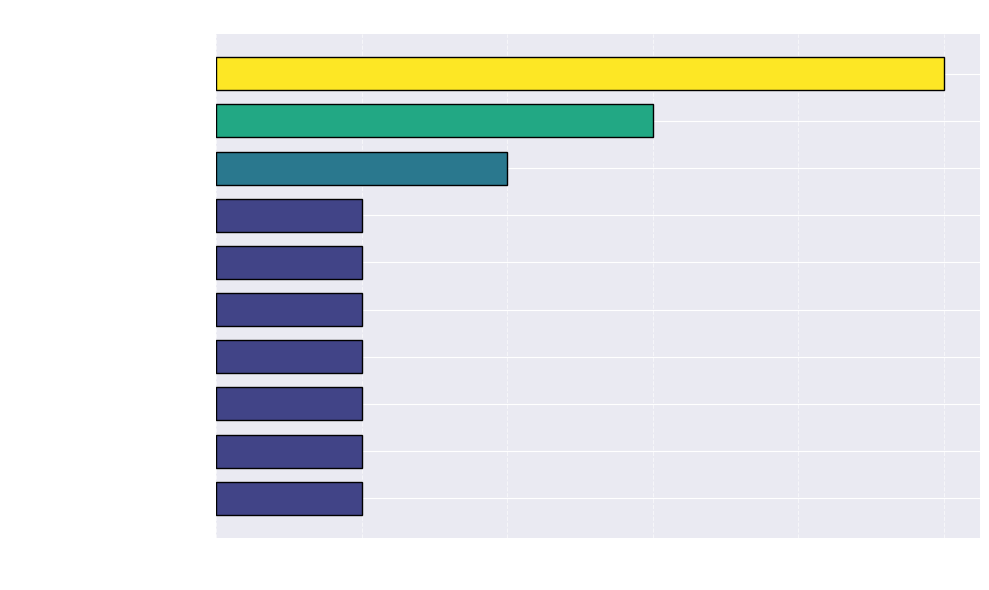

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Assuming 'author_information' is a dictionary containing information about all authors
all_interests = []

for author_info in author_information.values():
    interests = author_info.get('interests', [])
    all_interests.extend(interests)

# Lowercase all interests
all_interests = [interest.lower() for interest in all_interests]

# Count the occurrences of each interest
interests_counter = Counter(all_interests)

# Get the top N interests for plotting
top_n = 10
top_interests = dict(interests_counter.most_common(top_n))

# Set a custom style
plt.style.use('seaborn-darkgrid')

# Plot the bar chart with a color gradient and transparent background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # Set facecolor to 'none' for a transparent background
bars = ax.barh(list(top_interests.keys()), list(top_interests.values()), color=plt.cm.viridis(normalized_values), edgecolor='black', height=0.7)  # Use a color gradient with black edges for better visibility
ax.set_xlabel('Number of Authors', fontsize=14, color='white')  # x-axis label with adjusted font size and color
ax.set_ylabel('Interests', fontsize=14, color='white')  # y-axis label with adjusted font size and color
ax.set_title('Top Interests Across Authors', fontsize=16, color='white')  # Title with adjusted font size and color
ax.invert_yaxis()  # Invert y-axis for better readability
ax.grid(axis='x', linestyle='--', alpha=0.6, color='white')  # Add horizontal grid lines with a subtle color

# Set font color, size, and family to white for tick labels
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_color('white')
    tick.set_fontsize(12)
    tick.set_fontfamily('sans-serif')

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('top_interests_plot.png', transparent=True)  # Save the figure with a transparent background
plt.show()


In [122]:
# Assuming 'author_information' is a dictionary containing information about all authors
all_interests = []
author_interests = {}

# Extract interests and count occurrences
for author, author_info in author_information.items():
    interests = author_info.get('interests', [])
    lowercase_interests = [interest.lower() for interest in interests]
    all_interests.extend(lowercase_interests)

    # Store interests for each author
    author_interests[author] = lowercase_interests

# Count the occurrences of each interest
interests_counter = Counter(all_interests)

# Get the top N interests
top_n = 10
top_interests = dict(interests_counter.most_common(top_n))

# Display the authors for each top interest
for interest in top_interests:
    authors_with_interest = [author for author, interests in author_interests.items() if interest in interests]
    print(f"Authors interested in '{interest}': {authors_with_interest}")


Authors interested in 'machine learning': ['Hao Li', 'Zheng Xu', 'Gavin Taylor', 'Christoph Studer', 'Tom Goldstein']
Authors interested in 'computer vision': ['Hao Li', 'Zheng Xu', 'Tom Goldstein']
Authors interested in 'optimization': ['Zheng Xu', 'Christoph Studer']
Authors interested in 'federated learning': ['Zheng Xu']
Authors interested in 'artificial intelligence': ['Gavin Taylor']
Authors interested in 'reinforcement learning': ['Gavin Taylor']
Authors interested in 'vlsi circuits and systems': ['Christoph Studer']
Authors interested in 'wireless communication': ['Christoph Studer']
Authors interested in 'signal processing': ['Christoph Studer']
Authors interested in 'numerical optimization': ['Tom Goldstein']
